# 「ガウス過程と機械学習」
# P.89 ガウス過程回帰のハイパーパラメータ推定

In [1]:
using LinearAlgebra
using Random
using ForwardDiff
using Plots

Random.seed!(12345)

MersenneTwister(12345)

## 観測データの生成

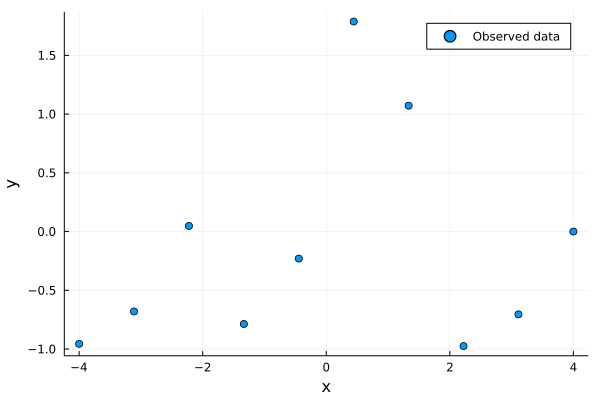

In [2]:
N = 10
X_train = range(-4, 4, length=N)
f(x) = sin(2x) + cos(x-π/5) + 0.1 * randn()
Y_train = f.(X_train)
θ = rand(3)
θ₁, θ₂, θ₃ = θ
scatter(X_train, Y_train, xlab="x", ylab="y", label="Observed data")

## ガウスカーネル関数を定義

In [3]:
k(x1, x2, θ₁, θ₂, θ₃) = θ₁ .* exp.(-(x1' .- x2).^2 ./ θ₂) + θ₃ .* (x1' .== x2)

k (generic function with 1 method)

## ガウスカーネルの微分

In [4]:
∂k∂θ₁(x1, x2, θ₁, θ₂, θ₃) = ForwardDiff.derivative(θ₁ -> k(x1, x2, θ₁, θ₂, θ₃), θ₁)
∂k∂θ₂(x1, x2, θ₁, θ₂, θ₃) = ForwardDiff.derivative(θ₂ -> k(x1, x2, θ₁, θ₂, θ₃), θ₂)
∂k∂θ₃(x1, x2, θ₁, θ₂, θ₃) = ForwardDiff.derivative(θ₃ -> k(x1, x2, θ₁, θ₂, θ₃), θ₃)

∂k∂θ₃ (generic function with 1 method)

In [5]:
∇K₁ = ∂k∂θ₁(X_train, X_train, θ₁, θ₂, θ₃)

10×10 Matrix{Float64}:
 1.0          0.447031     0.0399347    …  4.18407e-23  4.75703e-29
 0.447031     1.0          0.447031        7.35422e-18  4.18407e-23
 0.0399347    0.447031     1.0             2.58315e-13  7.35422e-18
 0.000712914  0.0399347    0.447031        1.81316e-9   2.58315e-13
 2.54331e-6   0.000712914  0.0399347       2.54331e-6   1.81316e-9
 1.81316e-9   2.54331e-6   0.000712914  …  0.000712914  2.54331e-6
 2.58315e-13  1.81316e-9   2.54331e-6      0.0399347    0.000712914
 7.35422e-18  2.58315e-13  1.81316e-9      0.447031     0.0399347
 4.18407e-23  7.35422e-18  2.58315e-13     1.0          0.447031
 4.75703e-29  4.18407e-23  7.35422e-18     0.447031     1.0

In [6]:
∇K₂ = ∂k∂θ₂(X_train, X_train, θ₁, θ₂, θ₃)

10×10 Matrix{Float64}:
 0.0          0.210289     0.075143     …  1.25967e-21  1.81259e-27
 0.210289     0.0          0.210289        1.69516e-16  1.25967e-21
 0.075143     0.210289     0.0             4.37452e-12  1.69516e-16
 0.00301827   0.075143     0.210289        2.13234e-8   4.37452e-12
 1.91425e-5   0.00301827   0.075143        1.91425e-5   2.13234e-8
 2.13234e-8   1.91425e-5   0.00301827   …  0.00301827   1.91425e-5
 4.37452e-12  2.13234e-8   1.91425e-5      0.075143     0.00301827
 1.69516e-16  4.37452e-12  2.13234e-8      0.210289     0.075143
 1.25967e-21  1.69516e-16  4.37452e-12     0.0          0.210289
 1.81259e-27  1.25967e-21  1.69516e-16     0.210289     0.0

In [7]:
∇K₃ = ∂k∂θ₃(X_train, X_train, θ₁, θ₂, θ₃)

10×10 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

## ハイパーパラメータ推定（勾配法）

In [8]:
X_test = rand((-6):0.1:6, 40)
niters = 100

for _ in 1:niters
    θ₁, θ₂, θ₃ = θ
    lr = [0.1, 0.01, 0.001]
    
    K = k(X_train, X_train, θ₁, θ₂, θ₃)
    invK = inv(K)
    likehood = -log(det(K)) - Y_train' * invK * Y_train
    @show likehood
    k_ = k(X_test, X_train, θ₁, θ₂, θ₃)
    k__ = k(X_test, X_test, θ₁, θ₂, θ₃)
    
    μ̂ = k_' * invK * Y_train
    Σ̂ = k__ - k_' * invK * k_
    
    invKy = invK * Y_train
    ∇L₁ = -tr(invK * ∇K₁) + (invKy' * ∇K₁ * invKy)
    ∇L₂ = -tr(invK * ∇K₂) + (invKy' * ∇K₂ * invKy) 
    ∇L₃ = -tr(invK * ∇K₃) + (invKy' * ∇K₃ * invKy)
    ∇L = [∇L₁, ∇L₂, ∇L₃]
    @show ∇L
    
    θ .-= lr .* -∇L
    @show θ
    
    # θが負になると invK の計算ができなくなるため最適化を終了する
    if θ[3] < 0
        θ .+= lr .* -∇L
        break
    end
end

@show θ

likehood = -7.458601033786364
∇L = [-2.1461435182903514, 0.4743952931484005, -3.9836363786550306]
θ = [0.35876764083720464, 0.9861080902135276, 0.582614464411893]
likehood = -7.0935184441268
∇L = [-0.9022548021471284, 0.41153502715619517, -2.9369821829387774]
θ = [0.2685421606224918, 0.9902234404850896, 0.5796774822289542]
likehood = -7.049468090104372
∇L = [0.18490950888529234, 0.38772950433076586, -2.0190094151818077]
θ = [0.28703311151102107, 0.9941007355283973, 0.5776584728137724]
likehood = -7.043167579025827
∇L = [-0.05145030917234372, 0.39261586275380667, -2.225176034127644]
θ = [0.28188808059378667, 0.9980268941559354, 0.5754332967796447]
likehood = -7.037642259506667
∇L = [0.04586158799594742, 0.39206624661680245, -2.148516843324444]
θ = [0.2864742393933814, 1.0019475566221034, 0.5732847799363203]
likehood = -7.032134348946439
∇L = [0.008172676538684698, 0.3939144445506965, -2.1865560825017134]
θ = [0.28729150704724987, 1.0058867010676105, 0.5710982238538186]
likehood = -7.026

likehood = -6.683443822741525
∇L = [0.029853536619876664, 0.4980154706729939, -2.663819766753411]
θ = [0.4216835319135402, 1.2561315353729834, 0.4345739450014677]
likehood = -6.676543594823859
∇L = [0.030180697985009886, 0.5009363253942897, -2.676346252518268]
θ = [0.4247016017120412, 1.2611408986269264, 0.4318975987489494]
likehood = -6.66961003102465
∇L = [0.030515500053727607, 0.5039189988016382, -2.6890850954850887]
θ = [0.42775315171741396, 1.2661800886149428, 0.4292085136534643]
likehood = -6.662642646028974
∇L = [0.03085818734344059, 0.5069654427940531, -2.702042238317768]
θ = [0.430838970451758, 1.2712497430428833, 0.4265064714151465]
likehood = -6.655640938478065
∇L = [0.031209014599957285, 0.5100776842336272, -2.715223848046442]
θ = [0.4339598719117537, 1.2763505198852196, 0.42379124756710007]
likehood = -6.64860439029703
∇L = [0.031568247320979737, 0.5132578284011722, -2.728636326668992]
θ = [0.4371166966438517, 1.2814830981692313, 0.4210626112404311]
likehood = -6.641532465

3-element Vector{Float64}:
 0.5641055717138266
 1.4680915050846854
 0.32482385336826974

## ガウス過程回帰を計算

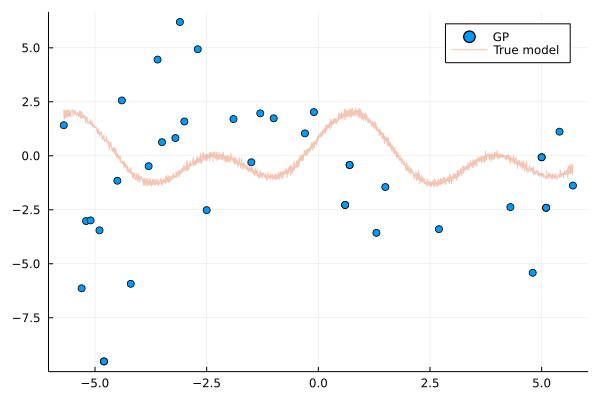

In [9]:
θ₁init, θ₂init, θ₃init = (10.0, 10.0, 10.0)
K = k(X_train, X_train, θ₁init, θ₂init, θ₃init)
k_ = k(X_test, X_train, θ₁init, θ₂init, θ₃init)
k__ = k(X_test, X_test, θ₁init, θ₂init, θ₃init)

Λ = inv(K)
Σ̂ = k__ - k_' * Λ * k_
μ̂ = k_' * Λ * Y_train

ŷ = μ̂ + real(√Σ̂) * randn(length(X_test))

scatter(X_test, ŷ, label="GP")
plot!(f, alpha=0.4, label="True model")

## ガウス過程回帰を計算（ハイパーパラメータ最適化）

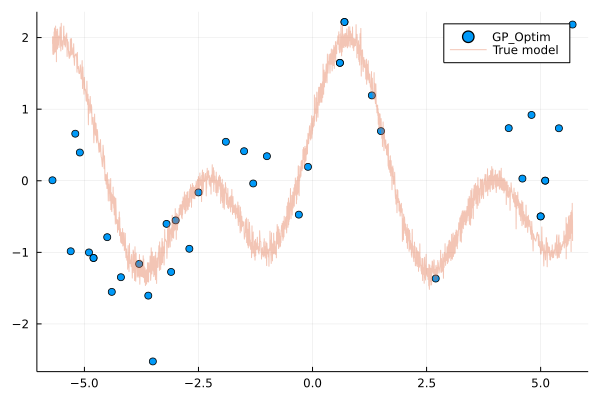

In [10]:
K = k(X_train, X_train, θ[1], θ[2], θ[3])
k_ = k(X_test, X_train, θ[1], θ[2], θ[3])
k__ = k(X_test, X_test, θ[1], θ[2], θ[3])

Λ = inv(K)
Σ̂ = k__ - k_' * Λ * k_
μ̂ = k_' * Λ * Y_train

ŷ = μ̂ + real(√Σ̂) * randn(length(X_test))

scatter(X_test, ŷ, label="GP_Optim")
plot!(f, alpha=0.4, label="True model")